# CSI 5138 - Assignment 3_ Phani Rohith Maganti

# IMDB Movie Review Dataset Analysis

Data Source: https://ai.stanford.edu/~amaas/data/sentiment/

The IMDB movie review dataset is a standard dataset for text classification or sentiment analysis.

Number of training reviews: 25000

Number of testing reviews:  25000

### Objective: 

Given a review, determine whether the review is postive or negative. To determine this two text classification models are used Vanilla RNN and LSTM


### 1. Importing all the necessary packages

In [72]:
#importing all necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, Dense, LSTM, GRU, Bidirectional, SimpleRNN
import matplotlib.pyplot as plt
from keras.models import Sequential
from numpy import asarray
from numpy import zeros
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.layers import Dropout, LeakyReLU, MaxPooling2D
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import csv
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from prettytable import PrettyTable

### 2. Load dataset

In [2]:
#List of datasets available on tensorflow - https://www.tensorflow.org/datasets/catalog/overview
#Importing imdb dataset from tensorflow datasets
imdb, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
#as_supervised: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default,
#the returned tf.data.Dataset will have a dictionary with all the features.
#With_info: `bool`, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.



Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQJIZ9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQJIZ9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFQJIZ9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## 3. Data Pre-processing

In [3]:
train_data, test_data = imdb['train'],imdb['test']

train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

#s = sentence, l = label
for s,l in train_data:
  train_sentences.append(s.numpy().decode('utf8'))
  train_labels.append(l.numpy())

for s,l in test_data:
  test_sentences.append(s.numpy().decode('utf8'))
  test_labels.append(l.numpy())

train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)

print('Training dataset size is: ', len(train_sentences))
print('Testing dataset size is', len(test_sentences))
print("A sample sentence: ", train_sentences[0])
print("Class label: ", train_labels[0])

#Tokenizing the sentences 
vocab_size = 10000
embedding_dim = 200
max_length = 200
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"

#Initalizing tokenizer 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

#Fitting the tokenizer on the training sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index


#Word indexing and padding on the train text sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding = padding_type, truncating=trunc_type)

#Word indexing and padding on the train text sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



Training dataset size is:  25000
Testing dataset size is 25000
A sample sentence:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Class label:  0


Loading word embedding from Pre-Trainted GloVe 

Source: https://nlp.stanford.edu/projects/glove/

**Word Embedding** is a method to represent words and documents in a dense vector format. This vector represents the projection of a word into a continous vector space and the projection is based on the words that surround the word when it is used. The position of the word is referred to as **Embedding.**

GloVe (Global Vectors for Word Representation):  GloVe provides a set of pre-tarined word embeddings.

The package of embedding that we will be using is **glove.twitter.27B.zip** of size 1.42 GB. It was trained on 1.2 Million vocabulary of a dataset of 2B tweets. This embedding provides embedding vector sizes of 25, 50, 100, 200 Dimensions.


In [4]:
#Making a connection to our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# open embedding from the drive into memory file
embeddings_index = {};
with open('/content/drive/My Drive/CSI 5138/glove.6B.200d.txt') as f:
	
  for line in f:
	  values = line.split()
	  word = values[0]
	  coefs = asarray(values[1:], dtype='float32')
	  embeddings_index[word] = coefs
  f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_dim

200

In [6]:
# create a weight matrix for words in training docs
number_of_words = len(word_index)
embedding_matrix = np.zeros((number_of_words, embedding_dim));
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word);
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector;

## 4. Defining the model

#### Vanilla RNN

In [ ]:
def vrnn(dimension,dropout_value,learning_rate):
  model = Sequential()
  model.add(Embedding(number_of_words,200,weights = [embedding_matrix],input_length=200,trainable = False))
  model.add(Dropout(dropout_value))
  model.add(SimpleRNN(dimension))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate),metrics = ['accuracy'])
  model.summary()
  return model
 

#### LSTM (Multi Layer)



In [7]:
def lstm(dimension,dropout_value,learning_rate):
  model = Sequential()
  model.add(Embedding(number_of_words,200,weights = [embedding_matrix],input_length=200,trainable = False))
  model.add(Dropout(dropout_value))
  model.add(Bidirectional(LSTM(dimension,return_sequences = True)))
  #return_sequences = True ensures that output of an LSTM match the inputs of the next LSTM
  model.add(Bidirectional(LSTM((int(dimension/2)))))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate),metrics = ['accuracy'])
  model.summary()
  return model

## 5. Executing the experiments

Here I am going to execute the vanilla RNN and LSTM model using the below Hyperparameters:



*  Dimensions = [20,50,100,200,500]  

*  Dropouts = [0,0.5]

*   Learning rates = [1e-4,3e-4]


#### 5.1 Vanilla RNN

##### State Dimension: 20

In [ ]:
#Dimensions = 20,  dropout = 0, Learning Rate = 1e-4

model_vrnn = vrnn(20,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss,test_loss))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                4420      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 17,726,653
Trainable params: 10,053
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.735, Test Accuracy: 0.741
Train Loss: 0.560, Test Loss: 0.548


Best epoch: 38


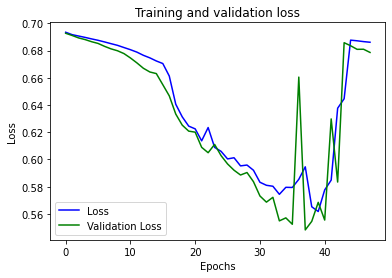

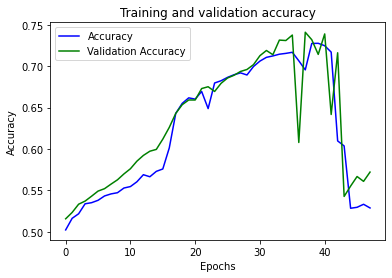

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-10    #Remove 10 epochs from the obtained as patience =10 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [76]:
vrnn_table = PrettyTable()
vrnn_table.field_names = ["Model","Dimensions","Dropout","Learning Rate","Best Epoch","train loss","test loss", "Accuracy"]

In [77]:
vrnn_table.add_row (["Vanilla RNN",20,0,"1e-4",38,0.56,0.54,74.1])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+


In [ ]:
#Dimensions = 20,  dropout = 0, Learning Rate = 3e-4

model_vrnn = vrnn(20,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.3f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.3f' % (train_loss,test_loss))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 20)                4420      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 17,726,653
Trainable params: 10,053
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6863, Test Accuracy: 0.686
Train Loss: 0.6141, Test Loss: 0.605


Best epoch: 17


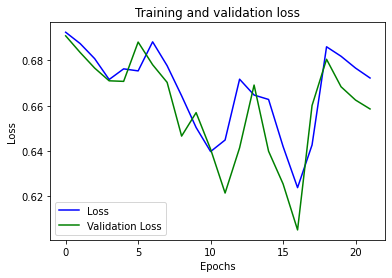

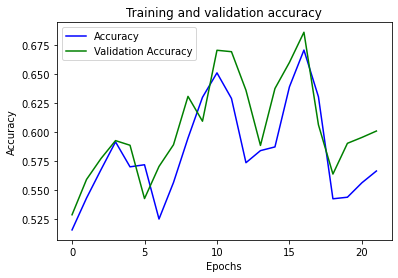

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [78]:
vrnn_table.add_row (["Vanilla RNN",20,0,"3e-4",17,0.61,0.60,68.6])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+


In [ ]:
#Dimensions = 20,  dropout = 0.5, Learning Rate = 1e-4

model_vrnn = vrnn(20,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20)                4420      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 17,726,653
Trainable params: 10,053
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6480, Test Accuracy: 0.6513
Train Loss: 0.6430, Test Loss: 0.6314


Best epoch: 49


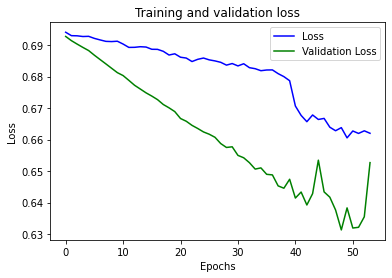

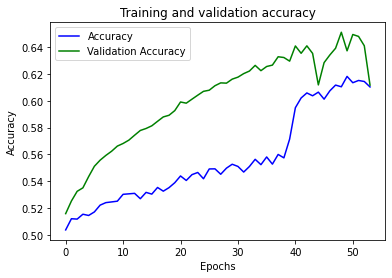

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [79]:
vrnn_table.add_row (["Vanilla RNN",20,0.5,"1e-4",49,0.64,0.63,65.1])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+


In [ ]:
#Dimensions = 20,  dropout = 0.5, Learning Rate = 3e-4

model_vrnn = vrnn(20,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 20)                4420      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 17,726,653
Trainable params: 10,053
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5744, Test Accuracy: 0.6082
Train Loss: 0.6779, Test Loss: 0.6614


Best epoch: 9


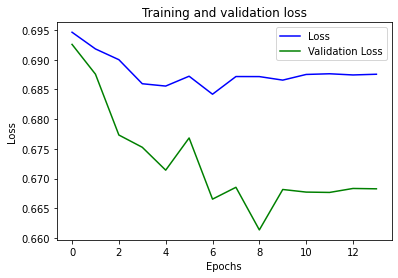

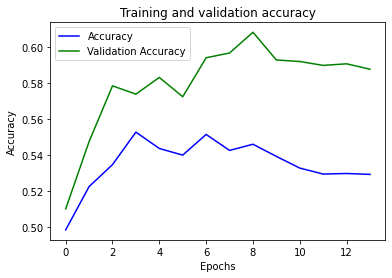

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [80]:
vrnn_table.add_row (["Vanilla RNN",20,0.5,"3e-4",9,0.67,0.66,60.8])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+


##### State Dimension: 50

In [ ]:
#Dimensions = 50,  dropout = 0, Learning Rate = 1e-4

model_vrnn = vrnn(50,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 50)                12550     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 17,742,463
Trainable params: 25,863
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.7401, Test Accuracy: 0.7452
Train Loss: 0.5571, Test Loss: 0.5489


Best epoch: 12


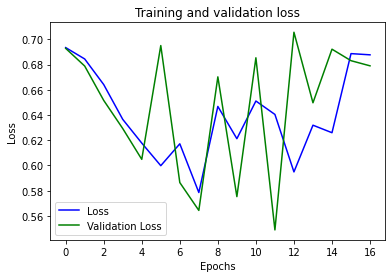

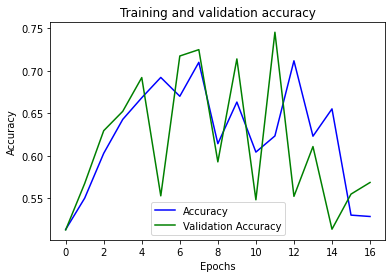

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [81]:
vrnn_table.add_row (["Vanilla RNN",50,0,"1e-4",12,0.55,0.54,74.5])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+


In [ ]:
#Dimensions = 50,  dropout = 0, Learning Rate = 3e-4

model_vrnn = vrnn(50,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 50)                12550     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 17,742,463
Trainable params: 25,863
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6488, Test Accuracy: 0.6307
Train Loss: 0.6343, Test Loss: 0.6517


Best epoch: 6


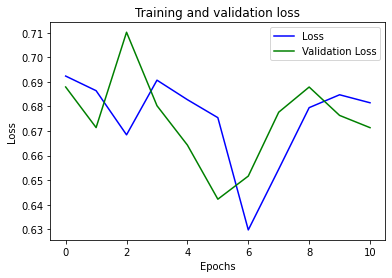

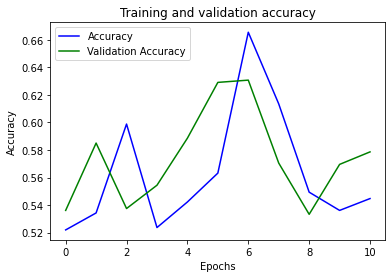

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [82]:
vrnn_table.add_row (["Vanilla RNN",50,0,"3e-4",6,0.63,0.65,63.0])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
+-------------+------------+---------+---------------+----------

In [ ]:
#Dimensions = 50,  dropout = 0.5, Learning Rate = 1e-4

model_vrnn = vrnn(50,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_11 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 50)                12550     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 17,742,463
Trainable params: 25,863
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6186, Test Accuracy: 0.6179
Train Loss: 0.6605, Test Loss: 0.6569


Best epoch: 10


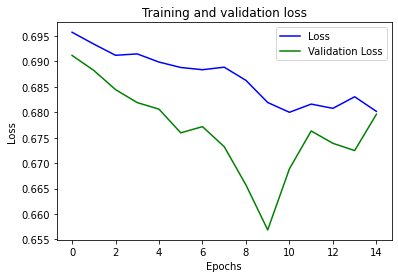

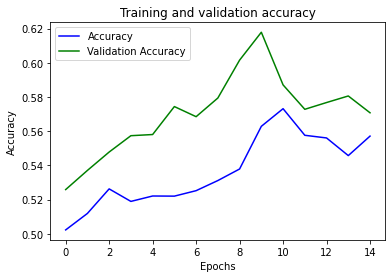

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [83]:
vrnn_table.add_row (["Vanilla RNN",50,0.5,"1e-4",10,0.66,0.65,61.7])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 50,  dropout = 0.5, Learning Rate = 3e-4

model_vrnn = vrnn(50,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_12 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 50)                12550     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 17,742,463
Trainable params: 25,863
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6179, Test Accuracy: 0.6072
Train Loss: 0.6567, Test Loss: 0.6554


Best epoch: 11


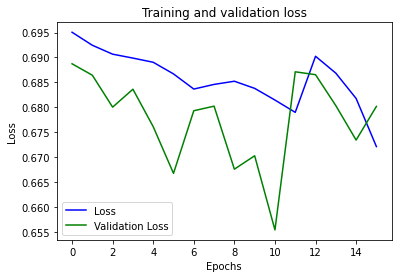

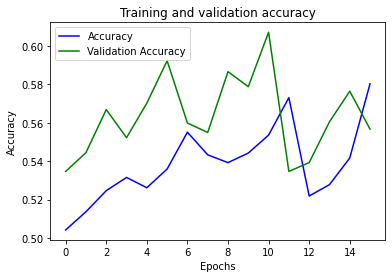

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [84]:
vrnn_table.add_row (["Vanilla RNN",50,0.5,"3e-4",11,0.65,0.65,60.7])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

##### State Dimension: 100

In [ ]:
#Dimensions = 100,  dropout = 0, Learning Rate = 1e-4

model_vrnn = vrnn(100,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_13 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 100)               30100     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 17,772,813
Trainable params: 56,213
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.7220, Test Accuracy: 0.7111
Train Loss: 0.5846, Test Loss: 0.5851


Best epoch: 12


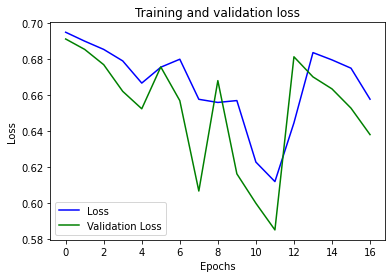

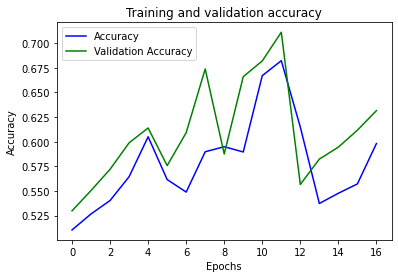

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [85]:
vrnn_table.add_row (["Vanilla RNN",100,0,"1e-4",12,0.58,0.58,71.1])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 100,  dropout = 0, Learning Rate = 3e-4

model_vrnn = vrnn(100,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_14 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 100)               30100     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 17,772,813
Trainable params: 56,213
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5758, Test Accuracy: 0.5970
Train Loss: 0.6597, Test Loss: 0.6697


Best epoch: 11


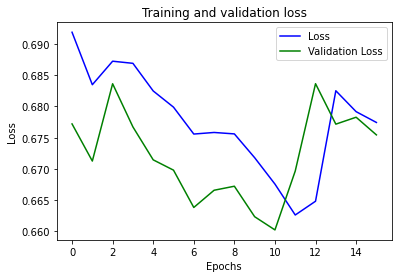

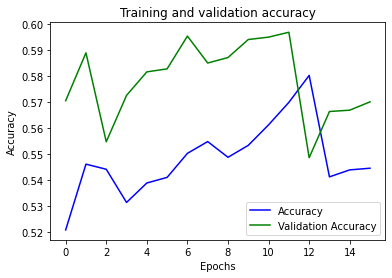

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [86]:
vrnn_table.add_row (["Vanilla RNN",100,0,"3e-4",11,0.65,0.66,59.7])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 100,  dropout = 0.5, Learning Rate = 1e-4

model_vrnn = vrnn(100,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 100)               30100     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 17,772,813
Trainable params: 56,213
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6049, Test Accuracy: 0.6104
Train Loss: 0.6658, Test Loss: 0.6589


Best epoch: 9


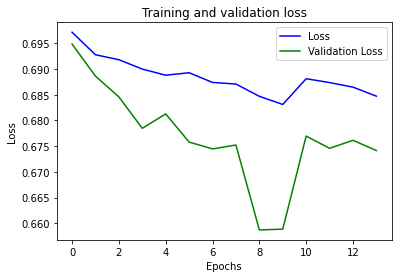

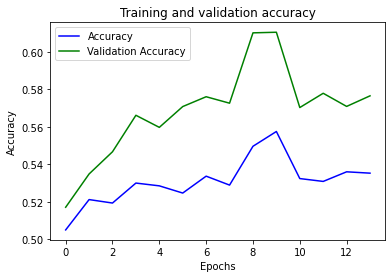

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [87]:
vrnn_table.add_row (["Vanilla RNN",100,0.5,"1e-4",9,0.66,0.65,61.0])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 100,  dropout = 0.5, Learning Rate = 3e-4

model_vrnn = vrnn(100,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_16 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 100)               30100     
_________________________________________________________________
dense_32 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 17,772,813
Trainable params: 56,213
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6620, Test Accuracy: 0.6492
Train Loss: 0.6294, Test Loss: 0.6351


Best epoch: 13


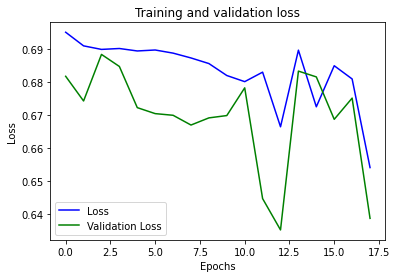

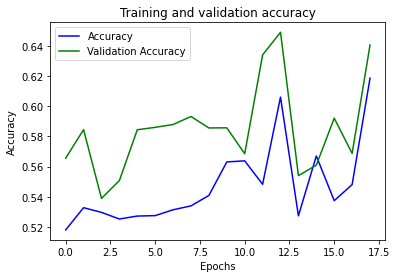

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [88]:
vrnn_table.add_row (["Vanilla RNN",100,0.5,"3e-4",13,0.62,0.63,64.9])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

##### State Dimension: 200

In [ ]:
#Dimensions = 200,  dropout = 0, Learning Rate = 1e-4

model_vrnn = vrnn(200,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_17 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 17,848,513
Trainable params: 131,913
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6540, Test Accuracy: 0.6275
Train Loss: 0.6357, Test Loss: 0.6472


Best epoch: 4


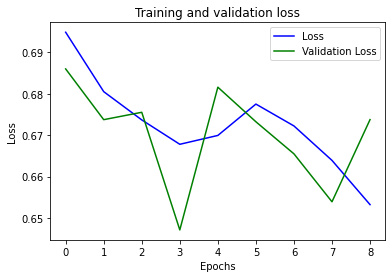

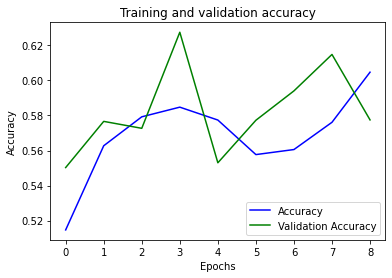

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [89]:
vrnn_table.add_row (["Vanilla RNN",200,0,"1e-4",4,0.63,0.64,62.7])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 200,  dropout = 0, Learning Rate = 3e-4

model_vrnn = vrnn(200,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_18 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_36 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 17,848,513
Trainable params: 131,913
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5587, Test Accuracy: 0.6045
Train Loss: 0.6743, Test Loss: 0.6587


Best epoch: 1


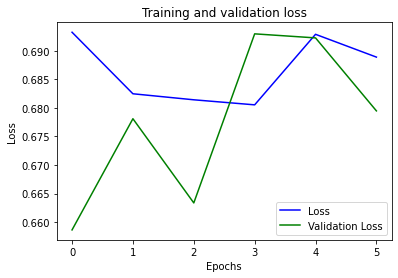

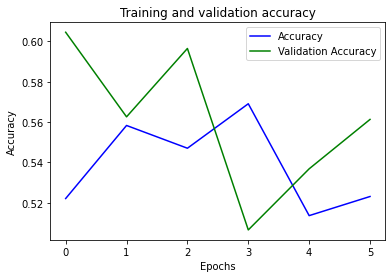

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [92]:
vrnn_table.add_row (["Vanilla RNN",200,0,"3e-4",1,0.67,0.65,60.4])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 200,  dropout = 0.5, Learning Rate = 1e-4

model_vrnn = vrnn(200,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_19 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 17,848,513
Trainable params: 131,913
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5450, Test Accuracy: 0.5749
Train Loss: 0.6809, Test Loss: 0.6760


Best epoch: 6


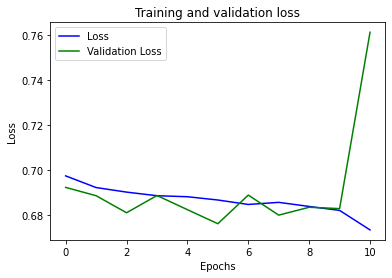

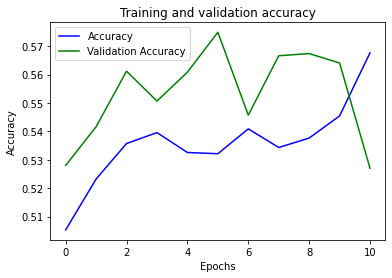

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [93]:
vrnn_table.add_row (["Vanilla RNN",200,0.5,"1e-4",6,0.68,0.67,57.4])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 200,  dropout = 0.5, Learning Rate = 3e-4

model_vrnn = vrnn(200,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_20 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_40 (Dense)             (None, 256)               51456     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 257       
Total params: 17,848,513
Trainable params: 131,913
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5506, Test Accuracy: 0.5976
Train Loss: 0.6811, Test Loss: 0.6621


Best epoch: 5


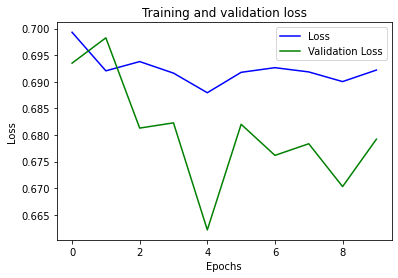

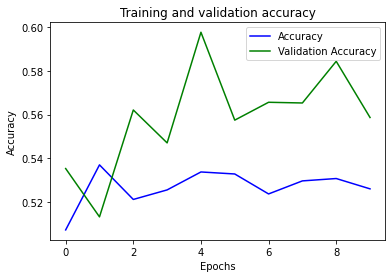

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [94]:
vrnn_table.add_row (["Vanilla RNN",200,0.5,"3e-4",5,0.68,0.66,59.7])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

##### State Dimension: 500

In [ ]:
#Dimensions = 500,  dropout = 0, Learning Rate = 1e-4

model_vrnn = vrnn(500,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_21 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, 500)               350500    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total params: 18,195,613
Trainable params: 479,013
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.7007, Test Accuracy: 0.6414
Train Loss: 0.6050, Test Loss: 0.6344


Best epoch: 5


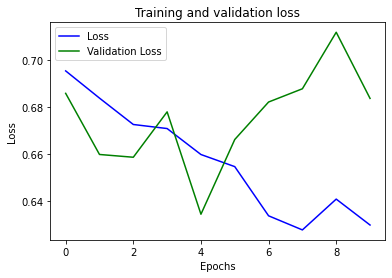

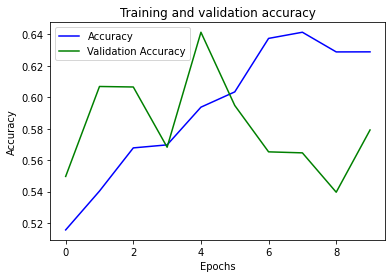

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [95]:
vrnn_table.add_row (["Vanilla RNN",500,0,"1e-4",5,0.60,0.63,64.1])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 500,  dropout = 0, Learning Rate = 3e-4

model_vrnn = vrnn(500,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_22 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 500)               350500    
_________________________________________________________________
dense_44 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 257       
Total params: 18,195,613
Trainable params: 479,013
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6184, Test Accuracy: 0.6224
Train Loss: 0.6503, Test Loss: 0.6504


Best epoch: 3


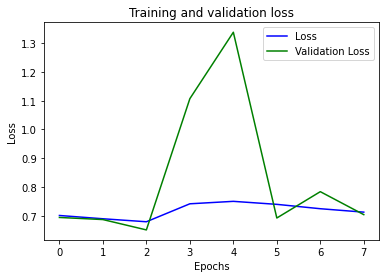

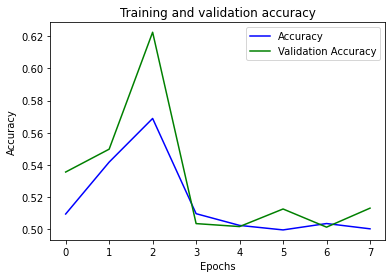

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [96]:
vrnn_table.add_row (["Vanilla RNN",500,0,"3e-4",3,0.65,0.65,62.2])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 500,  dropout = 0.5, Learning Rate = 1e-4

model_vrnn = vrnn(500,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_23 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 500)               350500    
_________________________________________________________________
dense_46 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 257       
Total params: 18,195,613
Trainable params: 479,013
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.6235, Test Accuracy: 0.6380
Train Loss: 0.6502, Test Loss: 0.6402


Best epoch: 7


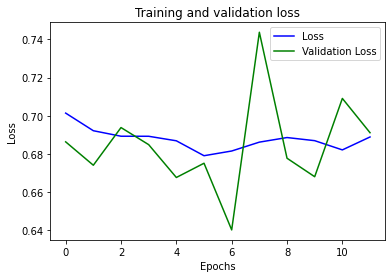

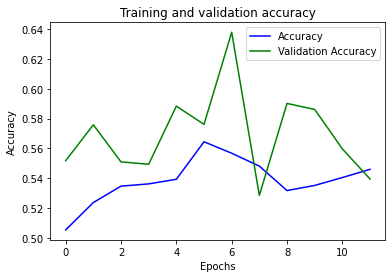

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [97]:
vrnn_table.add_row (["Vanilla RNN",500,0.5,"1e-4",7,0.65,0.64,63.8])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

In [ ]:
#Dimensions = 500,  dropout = 0.5, Learning Rate = 3e-4

model_vrnn = vrnn(500,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_vrnn.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_24 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 500)               350500    
_________________________________________________________________
dense_48 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 257       
Total params: 18,195,613
Trainable params: 479,013
Non-trainable params: 17,716,600
_________________________________________________________________
Train Accuracy: 0.5054, Test Accuracy: 0.5228
Train Loss: 0.6996, Test Loss: 0.6922


Best epoch: 6


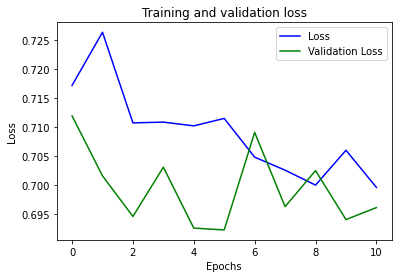

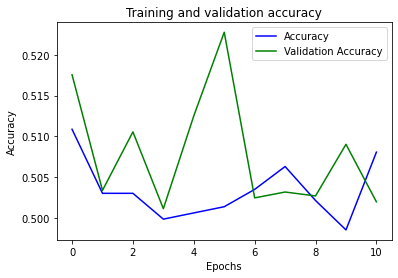

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

#### Vanilla RNN Table

In [98]:
vrnn_table.add_row (["Vanilla RNN",500,0.5,"3e-4",6,0.69,0.69,52.2])
print(vrnn_table)

+-------------+------------+---------+---------------+------------+------------+-----------+----------+
|    Model    | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------------+------------+---------+---------------+------------+------------+-----------+----------+
| Vanilla RNN |     20     |    0    |      1e-4     |     38     |    0.56    |    0.54   |   74.1   |
| Vanilla RNN |     20     |    0    |      3e-4     |     17     |    0.61    |    0.6    |   68.6   |
| Vanilla RNN |     20     |   0.5   |      1e-4     |     49     |    0.64    |    0.63   |   65.1   |
| Vanilla RNN |     20     |   0.5   |      3e-4     |     9      |    0.67    |    0.66   |   60.8   |
| Vanilla RNN |     50     |    0    |      1e-4     |     12     |    0.55    |    0.54   |   74.5   |
| Vanilla RNN |     50     |    0    |      3e-4     |     6      |    0.63    |    0.65   |   63.0   |
| Vanilla RNN |     50     |   0.5   |      1e-4     |     10   

## LSTM Model

#### Dimensions = 20

In [9]:
#Dimensions = 20,  dropout = 0, Learning Rate = 1e-4

model_lstm = lstm(20,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 40)           35360     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20)                4080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Best epoch: 30


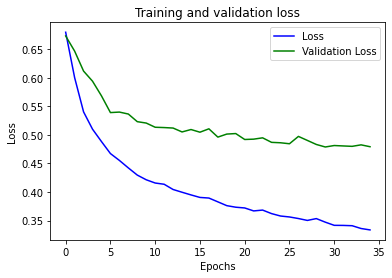

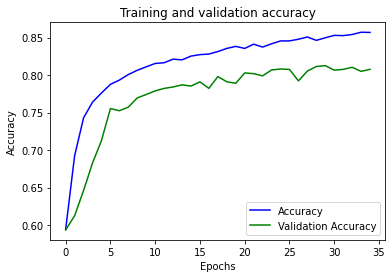

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [99]:
lstm_table = PrettyTable()
lstm_table.field_names = ["Model","Dimensions","Dropout","Learning Rate","Best Epoch","train loss","test loss", "Accuracy"]


In [100]:
lstm_table.add_row (["LSTM",20,0,"1e-4",30,0.33,0.47,81.25])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


In [15]:
#Dimensions = 20,  dropout = 0, Learning Rate = 3e-4

model_lstm = lstm(20,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 40)           35360     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20)                4080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

Best epoch: 31


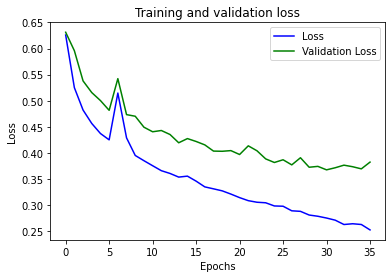

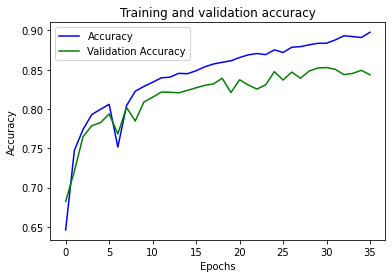

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [101]:
lstm_table.add_row(["LSTM",20,0,"3e-4",31,0.25,0.36,85.28])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


In [18]:
#Dimensions = 20,  dropout = 0.5, Learning Rate = 1e-4

model_lstm = lstm(20,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 40)           35360     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 20)                4080      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Best epoch: 17


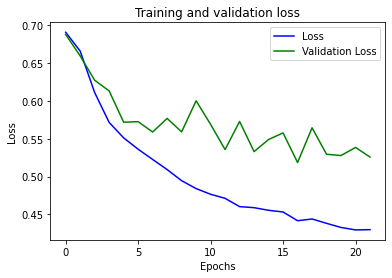

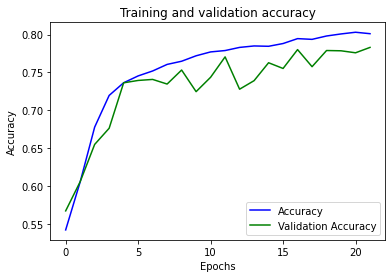

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [102]:
lstm_table.add_row(["LSTM",20,0.5,"1e-4",17,0.48,0.52,78.31])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


In [21]:
#Dimensions = 20,  dropout = 0.5, Learning Rate = 3e-4

model_lstm = lstm(20,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 40)           35360     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20)                4080      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1344      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

Best epoch: 17


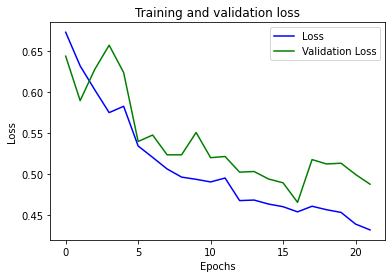

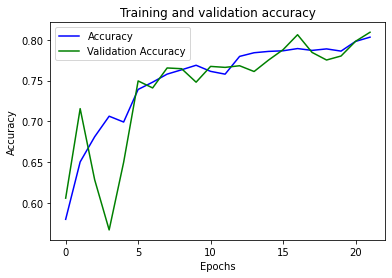

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [103]:
lstm_table.add_row(["LSTM",20,0.5,"3e-4",17,0.39,0.48,80.94])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


#### Dimensions - 50

In [24]:
#Dimensions = 50,  dropout = 0, Learning Rate = 1e-4

model_lstm = lstm(50,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200, 100)          100400    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50)                25200     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

Best epoch: 13


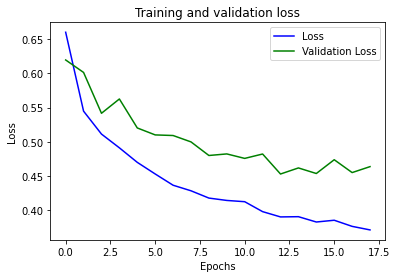

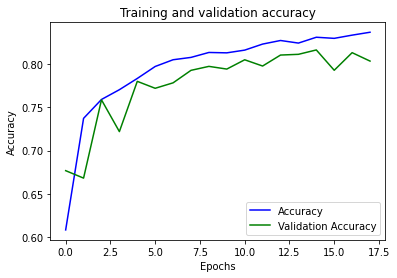

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [104]:
lstm_table.add_row(["LSTM",50,0,"1e-4",13,0.37,0.45,81.67])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


In [27]:
#Dimensions = 50,  dropout = 0, Learning Rate = 3e-4

model_lstm = lstm(50,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200, 100)          100400    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 50)                25200     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

Best epoch: 25


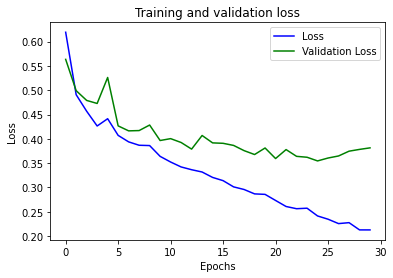

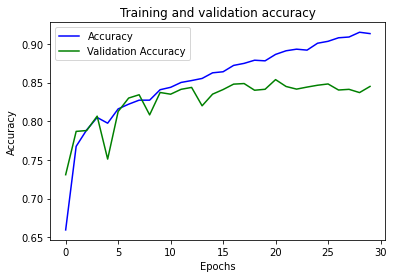

In [28]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [105]:
lstm_table.add_row(["LSTM",50,0,"3e-4",25,0.26,0.35,85.38])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
+-------+------------+---------+---------------+------------+------------+-----------+----------+


In [30]:
#Dimensions = 50,  dropout = 0.5, Learning Rate = 1e-4

model_lstm = lstm(50,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 200, 100)          100400    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50)                25200     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

Best epoch: 33


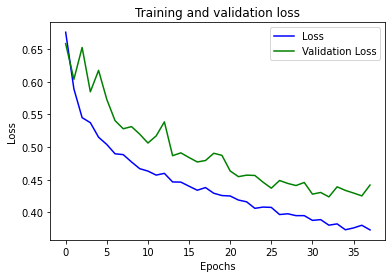

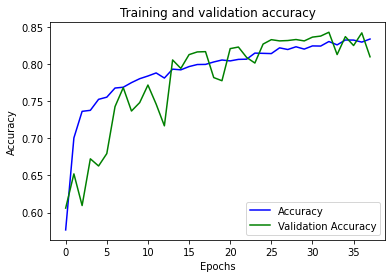

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [106]:
lstm_table.add_row(["LSTM",50,0.5,"1e-4",33,0.34,0.42,84.27])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
+-------+-----------

In [33]:
#Dimensions = 50,  dropout = 0.5, Learning Rate = 3e-4

model_lstm = lstm(50,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200, 100)          100400    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 50)                25200     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

Best epoch: 11


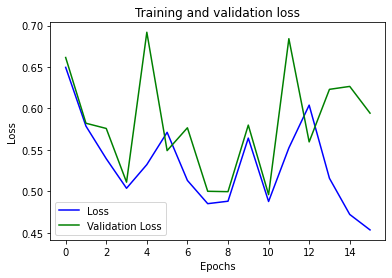

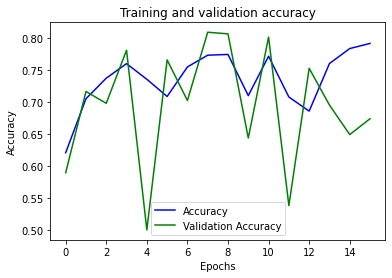

In [34]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [107]:
lstm_table.add_row(["LSTM",50,0.5,"3e-4",11,0.45,0.50,80.88])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

#### Dimensions: 100

In [36]:
#Dimensions = 100,  dropout = 0, Learning Rate = 1e-4

model_lstm = lstm(100,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 200)          17716600  
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200, 200)          240800    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_27 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                

Best epoch: 22


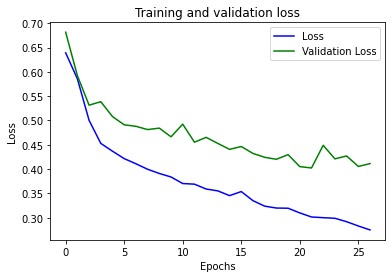

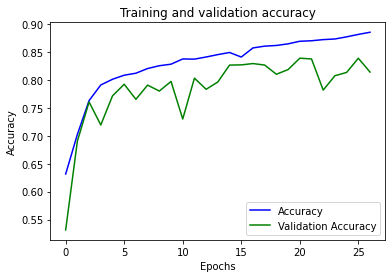

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [108]:
lstm_table.add_row(["LSTM",100,0,"1e-4",22,0.29,0.40,83.89])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [39]:
#Dimensions = 100,  dropout = 0, Learning Rate = 3e-4

model_lstm = lstm(100,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200, 200)          240800    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

Best epoch: 15


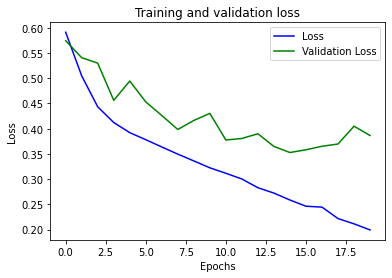

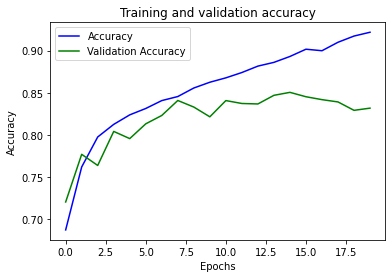

In [40]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [109]:
lstm_table.add_row(["LSTM",100,0,"3e-4",15,0.23,0.35,85.04])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [42]:
#Dimensions = 100,  dropout = 0.5, Learning Rate = 1e-4

model_lstm = lstm(100,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_11 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200, 200)          240800    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

Best epoch: 36


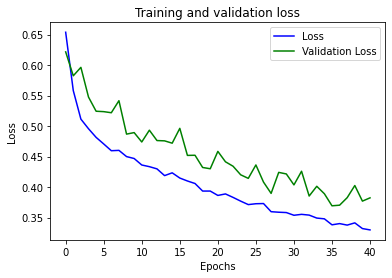

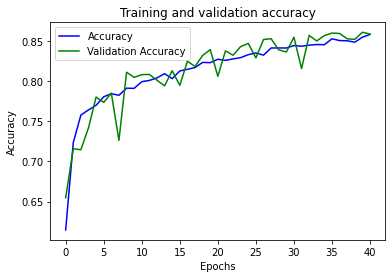

In [43]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [110]:
lstm_table.add_row(["LSTM",100,0.5,"1e-4",36,0.27,0.37,86.10])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [45]:
#Dimensions = 100,  dropout = 0.5, Learning Rate = 3e-4

model_lstm = lstm(100,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_12 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200, 200)          240800    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_36 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 1)               

Best epoch: 21


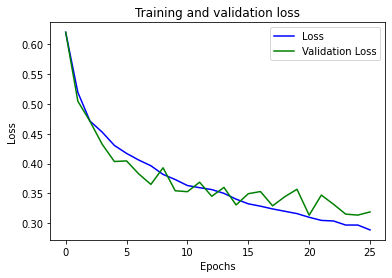

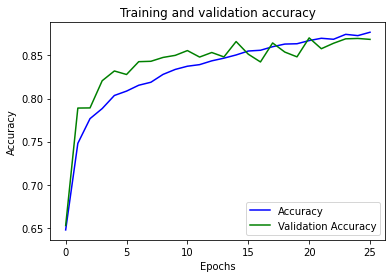

In [46]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [113]:
lstm_table.add_row(["LSTM",100,0.5,"3e-4",21,0.25,0.31,87.04])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

#### Dimensions: 200

In [48]:
#Dimensions = 200,  dropout = 0, Learning Rate = 1e-4

model_lstm = lstm(200,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_13 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 200, 400)          641600    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 200)               400800    
_________________________________________________________________
dense_39 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

Best epoch: 24


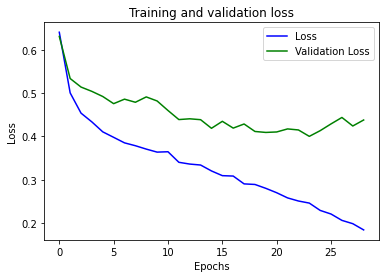

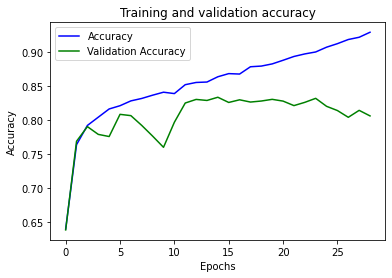

In [49]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [114]:
lstm_table.add_row(["LSTM",200,0,"1e-4",24,0.29,0.41,83.34])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [51]:
#Dimensions = 200,  dropout = 0, Learning Rate = 3e-4

model_lstm = lstm(200,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_14 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200, 400)          641600    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 200)               400800    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

Best epoch: 11


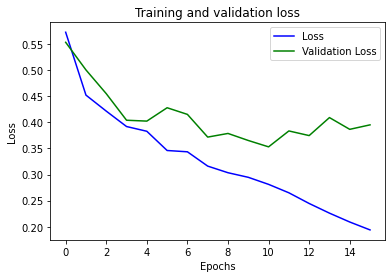

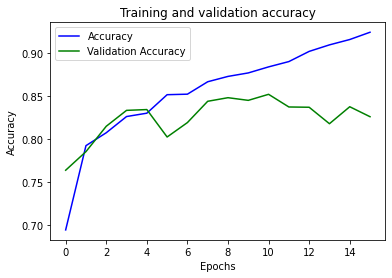

In [52]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [115]:
lstm_table.add_row(["LSTM",200,0,"3e-4",11,0.25,0.35,85.19])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [54]:
#Dimensions = 200,  dropout = 0.5, Learning Rate = 1e-4

model_lstm = lstm(200,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200, 400)          641600    
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 200)               400800    
_________________________________________________________________
dense_45 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

Best epoch: 23


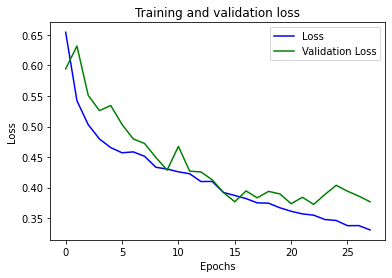

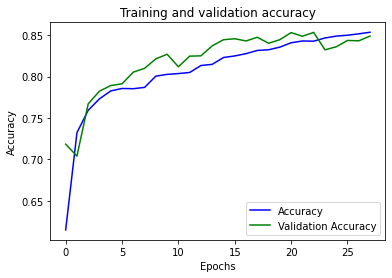

In [55]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [116]:
lstm_table.add_row(["LSTM",200,0.5,"1e-4",23,0.31,0.37,85.34])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [57]:
#Dimensions = 200,  dropout = 0.5, Learning Rate = 3e-4

model_lstm = lstm(200,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_16 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 200, 400)          641600    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 200)               400800    
_________________________________________________________________
dense_48 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_49 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_50 (Dense)             (None, 1)               

Best epoch: 16


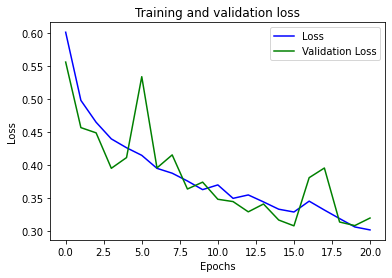

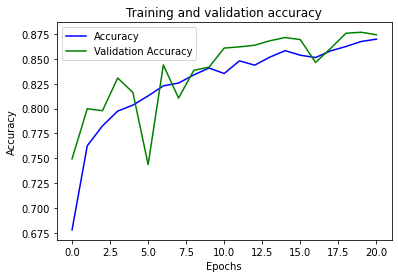

In [58]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [117]:
lstm_table.add_row(["LSTM",200,0.5,"3e-4",16,0.25,0.30,87.68])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

#### Dimensions: 500

In [60]:
#Dimensions = 500,  dropout = 0, Learning Rate = 1e-4

model_lstm = lstm(500,0,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_17 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 200, 1000)         2804000   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 500)               2502000   
_________________________________________________________________
dense_51 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_52 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

Best epoch: 11


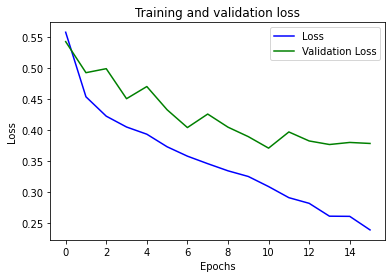

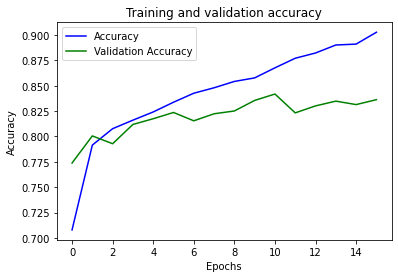

In [61]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [118]:
lstm_table.add_row(["LSTM",500,0,"1e-4",11,0.27,0.37,84.18])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [63]:
#Dimensions = 500,  dropout = 0, Learning Rate = 3e-4

model_lstm = lstm(500,0,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_18 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 200, 1000)         2804000   
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 500)               2502000   
_________________________________________________________________
dense_54 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_56 (Dense)             (None, 1)               

Best epoch: 7


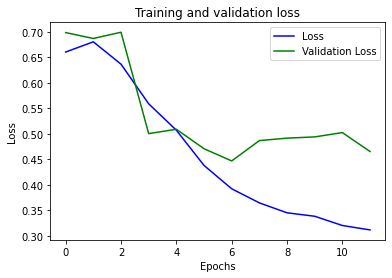

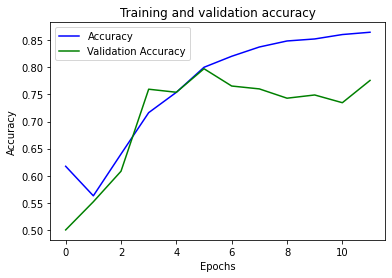

In [64]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [119]:
lstm_table.add_row(["LSTM",500,0,"3e-4",7,0.45,0.47,79.75])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [66]:
#Dimensions = 500,  dropout = 0.5, Learning Rate = 1e-4

model_lstm = lstm(500,0.5,1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_19 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 200, 1000)         2804000   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 500)               2502000   
_________________________________________________________________
dense_57 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_58 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

Best epoch: 28


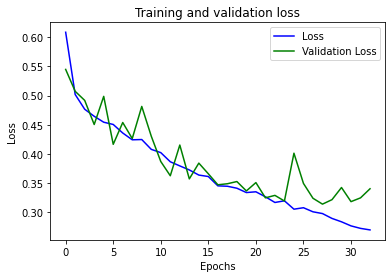

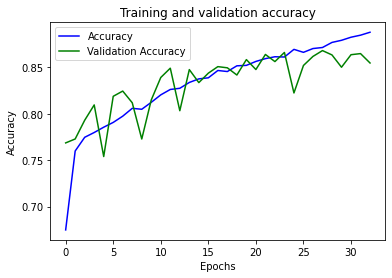

In [67]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [120]:
lstm_table.add_row(["LSTM",500,0.5,"1e-4",28,0.22,0.31,86.80])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

In [69]:
#Dimensions = 500,  dropout = 0.5, Learning Rate = 3e-4

model_lstm = lstm(500,0.5,3e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model_lstm.fit(padded, train_labels_final, epochs=100,batch_size=128, verbose =0, validation_data=(testing_padded, test_labels_final),callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
train_loss, train_acc = saved_model.evaluate(padded, train_labels_final, verbose=0)
test_loss, test_acc = saved_model.evaluate(testing_padded, test_labels_final, verbose=0)
print('Train Accuracy: %.4f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss,test_loss))


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 200)          17716600  
_________________________________________________________________
dropout_20 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 200, 1000)         2804000   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 500)               2502000   
_________________________________________________________________
dense_60 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_61 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 1)               

Best epoch: 3


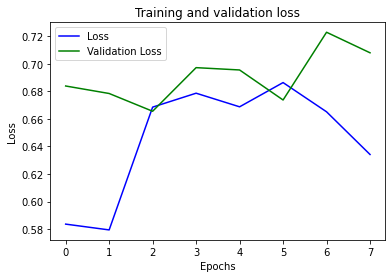

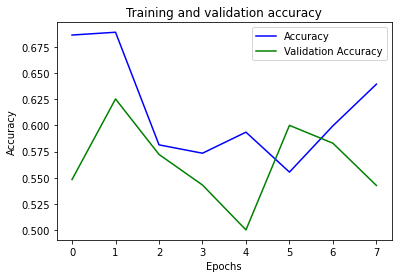

In [70]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(len(acc))
epochs = len(epochs_range)-5    #Remove 5 epochs from the obtained as patience =5 in EarlyStopping 
# Get number of epochs
print('Best epoch:',epochs)
#Plot of training and validation loss
plt.figure()
plt.plot(epochs_range, loss, 'b')
plt.plot(epochs_range, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

# Plot of training and validation accuracy 
plt.figure()
plt.plot(epochs_range, acc, 'b')
plt.plot(epochs_range, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

#### LSTM Table

In [121]:
lstm_table.add_row(["LSTM",500,0.5,"3e-4",3,0.66,0.67,62.54])
print(lstm_table)

+-------+------------+---------+---------------+------------+------------+-----------+----------+
| Model | Dimensions | Dropout | Learning Rate | Best Epoch | train loss | test loss | Accuracy |
+-------+------------+---------+---------------+------------+------------+-----------+----------+
|  LSTM |     20     |    0    |      1e-4     |     30     |    0.33    |    0.47   |  81.25   |
|  LSTM |     20     |    0    |      3e-4     |     31     |    0.25    |    0.36   |  85.28   |
|  LSTM |     20     |   0.5   |      1e-4     |     17     |    0.48    |    0.52   |  78.31   |
|  LSTM |     20     |   0.5   |      3e-4     |     17     |    0.39    |    0.48   |  80.94   |
|  LSTM |     50     |    0    |      1e-4     |     13     |    0.37    |    0.45   |  81.67   |
|  LSTM |     50     |    0    |      3e-4     |     25     |    0.26    |    0.35   |  85.38   |
|  LSTM |     50     |   0.5   |      1e-4     |     33     |    0.34    |    0.42   |  84.27   |
|  LSTM |     50    

## Conclusion: 

Model with LSTM outweighed vanilla RNN.

In the cases of RNN, the model with state dimensions 20 and 50 yielded good results. Whereas in the case of LSTM, we can observe good results across all the dimensions.

In the Vanilla RNN based model, as the number of dimensions increase, the accuracy value keeps decreasing. The models with 1e-4 learning rate simulated better results than 3e-4.
In the LSTM based model, as we increase the number of state dimensions the accuracy tends to increase. Also, the model with a 3e-4 learning rate yielded better results than 1e-4.

In the Vanilla RNN based model when the dropout is changed from 0 to 0.5, we can see a decrease in the accuracy. However, there’s no impact of dropout on the LSTM based model.
